C:\Users\USER\AppData\Local\Temp\ipykernel_24532\2281451225.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['흑승'] = filtered_data['결과'].str.contains('흑', na=False)


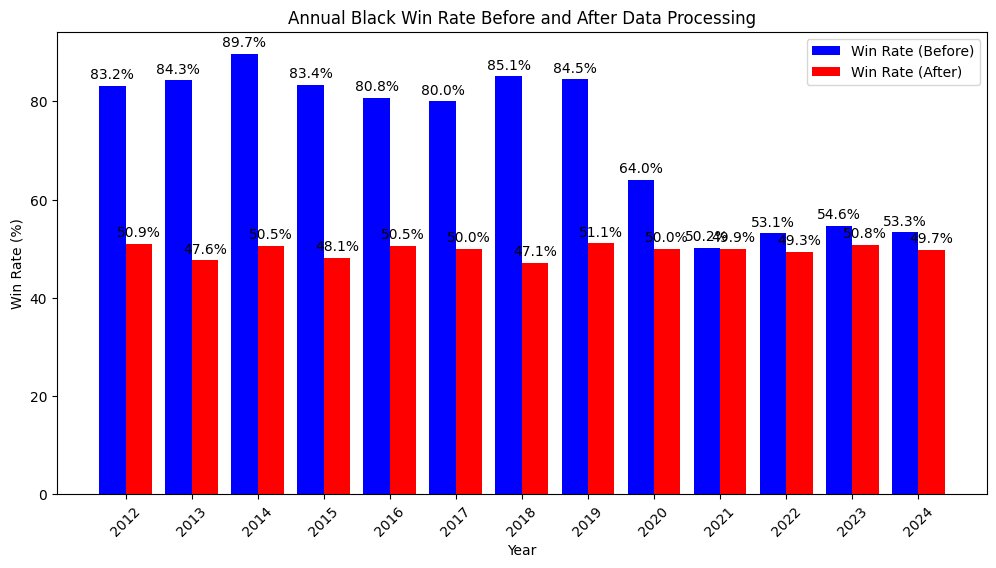

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. 데이터 병합
years = range(2012, 2025)  # 2012년부터 2024년까지
dataframes = []

# 연도별 데이터 읽어오기
for year in years:
    df = pd.read_csv(f"../data/baduk_{year}.csv")  # 파일 읽기
    df['연도'] = year  # 연도 컬럼 추가
    dataframes.append(df)

# 하나의 DataFrame으로 병합
all_data = pd.concat(dataframes, ignore_index=True)

# '날짜' 열을 datetime 형식으로 변환
all_data['날짜'] = pd.to_datetime(all_data['날짜'], errors='coerce')

# 전처리 전 흑승률 계산
all_data['연도'] = all_data['날짜'].dt.year  # 날짜에서 연도 추출
all_data = all_data.dropna(subset=['연도'])  # 연도 값이 없는 데이터 제거

# 흑이 승리한 대국
all_data['흑승'] = all_data['결과'].str.contains('흑', na=False)

# 연도별 흑승률 계산 (전처리 전)
yearly_stats_before = all_data.groupby('연도')['흑승'].agg(
    total_games='count',  # 연도별 총 대국 수
    black_wins='sum'  # 연도별 흑승 대국 수
)
yearly_stats_before['black_win_rate'] = (yearly_stats_before['black_wins'] / yearly_stats_before['total_games']) * 100

# 2. 결과 열에서 "xx수" 제거
if '결과' in all_data.columns:
    all_data['결과'] = all_data['결과'].str.replace(r"\d+수\s?", "", regex=True)

# 3. exclude_patterns 전처리
exclude_patterns = [
    "흑 기타", "백 기타", "흑 집승", "백 집승", " 무승부", "기권승",
    "기타", "무승부", "시간승", "흑", "반칙승", " 시간승", "실격승", " 무효", "양자패", "불계승"
]

# 결과 열에서 제외할 패턴 제거
filtered_data = all_data[~all_data['결과'].isin(exclude_patterns)]

# 4. 연도별 흑승률 계산 (전처리 후)
filtered_data['흑승'] = filtered_data['결과'].str.contains('흑', na=False)

# 연도별 흑승률 계산
yearly_stats_after = filtered_data.groupby('연도')['흑승'].agg(
    total_games='count',  # 연도별 총 대국 수
    black_wins='sum'  # 연도별 흑승 대국 수
)
yearly_stats_after['black_win_rate'] = (yearly_stats_after['black_wins'] / yearly_stats_after['total_games']) * 100

# 전처리 전후 비교 테이블 생성 (연도, 전처리 전 흑 승률, 전처리 후 흑 승률)
comparison_df = yearly_stats_before[['black_win_rate']].rename(
    columns={'black_win_rate': '흑승률(전)'}
).merge(
    yearly_stats_after[['black_win_rate']].rename(
        columns={'black_win_rate': '흑승률(후)'}
    ),
    left_index=True, right_index=True, how='outer'
)

# 승률을 소수점 둘째 자리에서 반올림하고 숫자로 변환
comparison_df = comparison_df.round(1)

# 연도를 인덱스로 설정 (이미 인덱스면 건너뜀)
if "연도" in comparison_df.columns:
    comparison_df.set_index("연도", inplace=True)

# 바 차트 그리기
x = np.arange(len(comparison_df.index))  # 연도별 위치 인덱스 생성
width = 0.4  # 바 너비 설정

fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(x - width/2, comparison_df['흑승률(전)'], width, label='Win Rate (Before)', color='blue')
bar2 = ax.bar(x + width/2, comparison_df['흑승률(후)'], width, label='Win Rate (After)', color='red')

# X축 설정
ax.set_xlabel('Year')
ax.set_ylabel('Win Rate (%)')
ax.set_title('Annual Black Win Rate Before and After Data Processing')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=45)

# 범례 추가
ax.legend()

# 바 위에 값 표시
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 값 위로 약간 이동
                    textcoords="offset points",
                    ha='center', va='bottom')

# 그래프 저장
plt.savefig("../figures/Black_win_rate.png", dpi=300, bbox_inches='tight')

# 그래프 출력
plt.show()